# openPose using openCV

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
net = cv.dnn.readNetFromTensorflow("./models/graph_opt.pb")

In [3]:
inWidth = 368
inHeight = 368
thr = 0.2

In [4]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [5]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, "%.2fms" % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    return frame

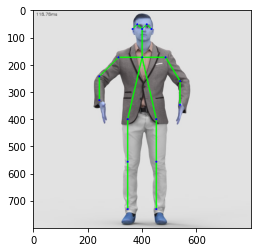

In [6]:
img = cv.imread("./models/image.jpg", cv.IMREAD_COLOR)
plt.imshow(img)

estimated = pose_estimation(img)
plt.imshow(estimated)

In [ ]:
vid = cv.VideoCapture("./models/mitmHal.mp4")
vid.set(3, 800)
vid.set(4, 800)

if not vid.isOpened():
    vid = cv.VideoCapture(0)
if not vid.isOpened():
    raise IOError("Cannot open")

while cv.waitKey(1) < 0:
    hasFrame, frame = vid.read()
    if not hasFrame:
        cv.waitKey()
        break

    cv.imshow("Pose Estimation", pose_estimation(frame))

# mpPose

In [14]:
import cv2
import mediapipe as mp
import time
import math

class poseDetector():
    # Under: https://google.github.io/mediapipe/images/mobile/pose_tracking_full_body_landmarks.png
    BODY_PARTS = {
        # Head
        0: "Nose", 
        1: "LeftEyeInner", 2: "LeftEye", 3: "LeftEyeOuter", 4: "RightEyeInner", 5: "RightEye", 6: "RightEyeOuter",
        7: "LeftEar", 8: "RightEar", 
        9: "MouthLeft", 10: "MouthRight",

        # Left arm + hand
        11: "LeftShoulder", 13: "LeftElbow", 15: "LeftWrist",
        17: "LeftPinky", 19: "LeftIndex", 21: "LeftThumb",
        # Right arm + hand
        12: "RightShoulder", 14: "RightElbow", 16: "RightWrist",
        18: "RightPinky",  20: "RightIndex",  22: "RightThumb",

        # Left foot
        23: "LeftHip", 25: "LeftKnee", 27: "LeftAnkle", 29: "LeftHeel", 31: "LeftFootIndex",
        # Right foot
        24: "RightHip", 26: "RightKnee", 28: "RightAnkle", 30: "RightHeel", 32: "RightFootIndex" 
    }

    def __init__(self, mode=False, upBody=False, smooth=True,
                 detectionCon=0.5, trackCon=0.5):

        self.mode = mode
        self.upBody = upBody
        self.smooth = smooth
        self.detectionCon = detectionCon
        self.trackCon = trackCon

        self.mpDraw = mp.solutions.drawing_utils
        self.mpPose = mp.solutions.pose
        self.pose = self.mpPose.Pose(self.mode, self.upBody, self.smooth,
                                     self.detectionCon, self.trackCon)

    def findPose(self, img, draw=True):
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.results = self.pose.process(imgRGB)
        if self.results.pose_landmarks:
            if draw:
                self.mpDraw.draw_landmarks(img, self.results.pose_landmarks,
                                           self.mpPose.POSE_CONNECTIONS)
        return img

    def findPosition(self, img, draw=True):
        self.lmDict = dict()
        if self.results.pose_landmarks:
            for id, lm in enumerate(self.results.pose_landmarks.landmark):
                h, w, c = img.shape
                # print(id, lm)
                cx, cy = int(lm.x * w), int(lm.y * h)
                self.lmDict[self.BODY_PARTS[id]] = [lm.x, lm.y, lm.z]
                if draw:
                    cv2.circle(img, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
        return self.lmDict

    def findAngle(self, img, p1, p2, p3, draw=True):

        # Get the landmarks
        x1, y1 = self.lmList[p1][1:]
        x2, y2 = self.lmList[p2][1:]
        x3, y3 = self.lmList[p3][1:]

        # Calculate the Angle
        angle = math.degrees(math.atan2(y3 - y2, x3 - x2) -
                             math.atan2(y1 - y2, x1 - x2))
        if angle < 0:
            angle += 360

        # print(angle)

        # Draw
        if draw:
            cv2.line(img, (x1, y1), (x2, y2), (255, 255, 255), 3)
            cv2.line(img, (x3, y3), (x2, y2), (255, 255, 255), 3)
            cv2.circle(img, (x1, y1), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (x1, y1), 15, (0, 0, 255), 2)
            cv2.circle(img, (x2, y2), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (x2, y2), 15, (0, 0, 255), 2)
            cv2.circle(img, (x3, y3), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (x3, y3), 15, (0, 0, 255), 2)
            cv2.putText(img, str(int(angle)), (x2 - 50, y2 + 50),
                        cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
        return angle

In [8]:
import cv2
import time
import json

cap = cv2.VideoCapture("videos/hal1.mp4")
pTime = 0
detector = poseDetector()

poses = []

while True:
    success, img = cap.read()
    if not success:
        cap.release()
        break

    img = detector.findPose(img)
    lmDict = detector.findPosition(img, draw=False)
    if len(lmDict) !=0:
        poses.append(lmDict)

    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime

    cv2.putText(img, str(int(fps)), (70, 50), cv2.FONT_HERSHEY_PLAIN, 3,
                (255, 0, 0), 3)

    cv2.imshow("Image", img)
    cv2.waitKey(1)

with open("./output/hal_poses.json", "w+") as f:
    json.dump(poses, f)